In [2]:
import pandas as pd

# Load the dataset
file_path = './Datasets/final-data/train_set_complete.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe and the data types of each column
data_info = data.info()
data_head = data.head()

data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   town                             60000 non-null  object 
 1   flat_model                       60000 non-null  object 
 2   floor_area_sqm                   60000 non-null  float64
 3   lease_commence_date              60000 non-null  int64  
 4   latitude                         60000 non-null  float64
 5   longitude                        60000 non-null  float64
 6   subzone                          60000 non-null  object 
 7   planning_area                    60000 non-null  object 
 8   region                           60000 non-null  object 
 9   monthly_rent                     60000 non-null  int64  
 10  rent_approval_year               60000 non-null  int64  
 11  rent_approval_month              60000 non-null  int64  
 12  coe_price         

(None,
             town      flat_model  floor_area_sqm  lease_commence_date  \
 0     ang mo kio  new generation            67.0                 1979   
 1  choa chu kang        improved           110.0                 2003   
 2       clementi  new generation            67.0                 1978   
 3    bukit batok         model a            74.0                 1984   
 4      sembawang         model a            93.0                 2002   
 
    latitude   longitude            subzone  planning_area             region  \
 0  1.366600  103.855579         chong boon     ang mo kio  north-east region   
 1  1.401158  103.751472            yew tee  choa chu kang        west region   
 2  1.316994  103.768507     clementi north       clementi        west region   
 3  1.347162  103.742808   bukit batok west    bukit batok        west region   
 4  1.450165  103.819307  sembawang central      sembawang       north region   
 
    monthly_rent  ...  mall_nearest_distance    mall_neares

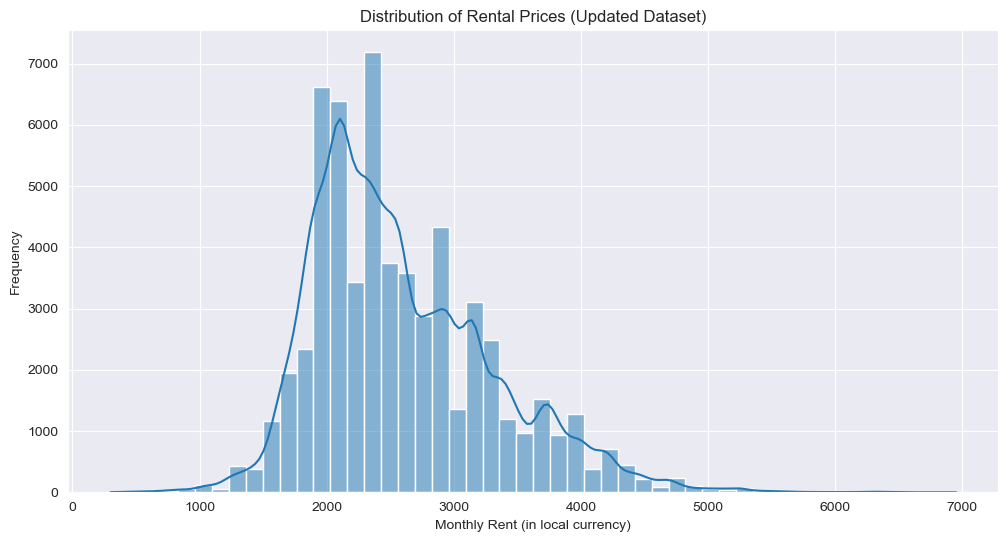

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

# Plot the distribution of rental prices from the updated dataset
plt.figure(figsize=(12, 6))
sns.histplot(data['monthly_rent'], bins=50, kde=True)
plt.title('Distribution of Rental Prices (Updated Dataset)')
plt.xlabel('Monthly Rent (in local currency)')
plt.ylabel('Frequency')
plt.show()

C:\Users\User\.conda\envs\project-tpot-38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


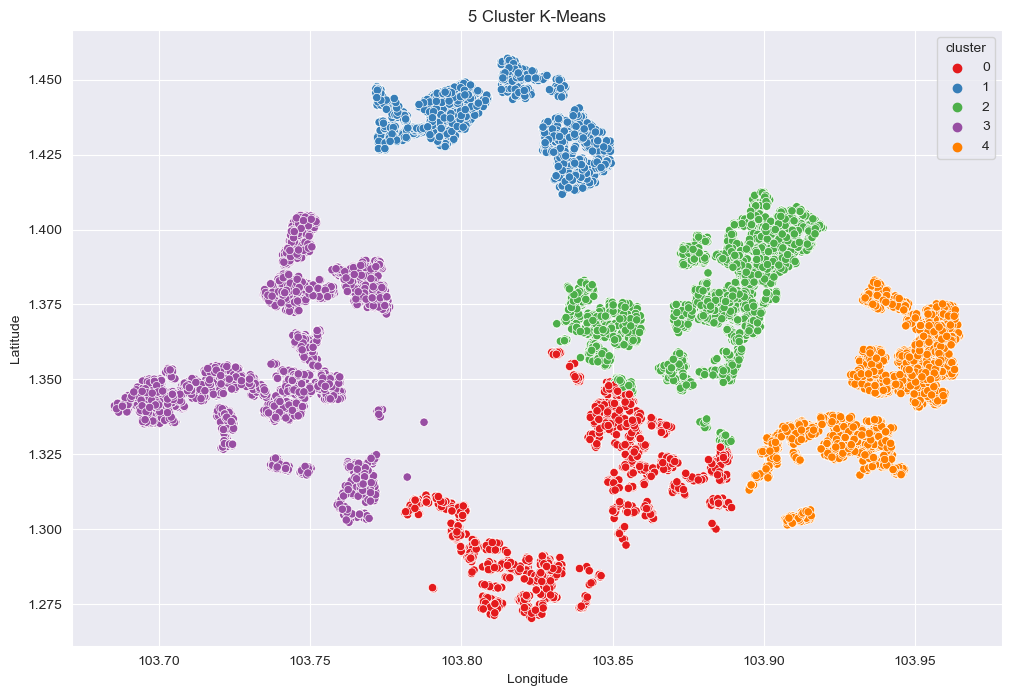

In [4]:
from sklearn.cluster import KMeans

# Perform k-means clustering with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=0)
data['cluster'] = kmeans.fit_predict(data[['latitude', 'longitude']])

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='longitude', y='latitude', data=data, hue='cluster', palette='Set1', legend='full')
plt.title('5 Cluster K-Means')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [5]:
# Calculate the average rent for each cluster
cluster_rent_avg = data.groupby('cluster')['monthly_rent'].mean().sort_values()

# Get the cluster with the highest and lowest average rent
highest_rent_cluster = cluster_rent_avg.idxmax()
lowest_rent_cluster = cluster_rent_avg.idxmin()

highest_rent_avg = cluster_rent_avg[highest_rent_cluster]
lowest_rent_avg = cluster_rent_avg[lowest_rent_cluster]

# Display the results
cluster_rent_avg, highest_rent_cluster, highest_rent_avg, lowest_rent_cluster, lowest_rent_avg

(cluster
 1    2450.623806
 3    2571.589413
 2    2574.688609
 4    2575.738674
 0    2743.124784
 Name: monthly_rent, dtype: float64,
 0,
 2743.124783662167,
 1,
 2450.6238064926797)

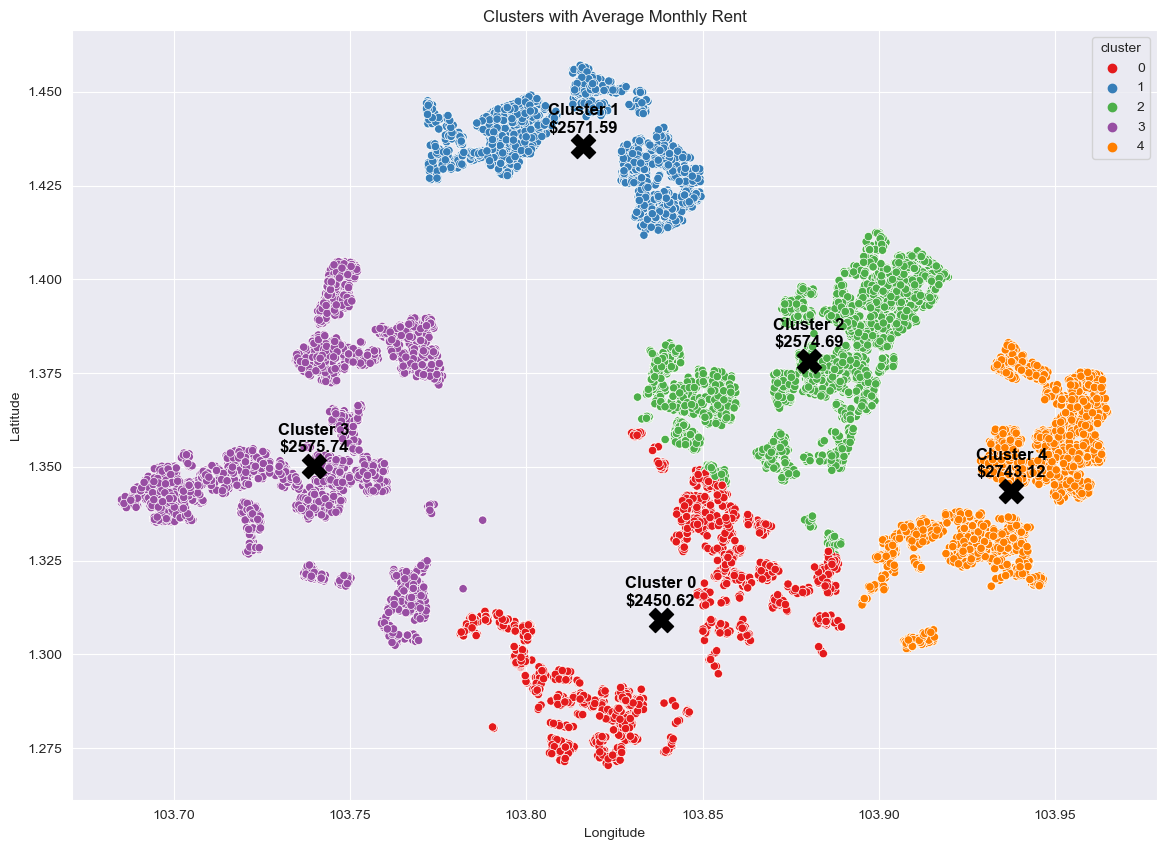

In [6]:
# Plot the clusters with the average rent annotated
plt.figure(figsize=(14, 10))
clusters = sns.scatterplot(x='longitude', y='latitude', data=data, hue='cluster', palette='Set1', legend='full')

# Plot the centroids of each cluster
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 1], centroids[:, 0], s=300, c='black', marker='X')

# Annotate the average rent on the centroids
for i, txt in enumerate(cluster_rent_avg):
    plt.annotate(f"Cluster {i}\n${txt:.2f}", (centroids[i][1], centroids[i][0]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color='black', weight='bold')

plt.title('Clusters with Average Monthly Rent')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

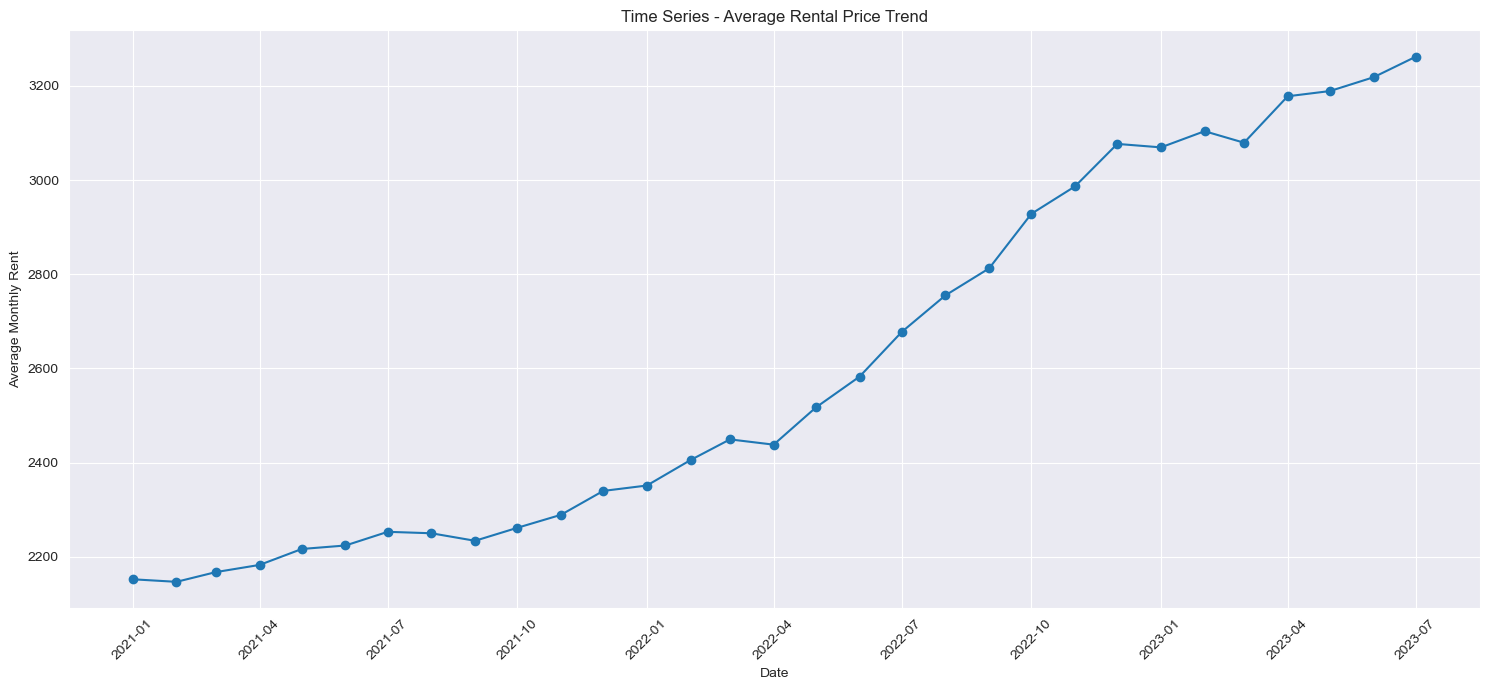

In [7]:
# Correct the approach to create a 'date' column
data['date'] = pd.to_datetime(dict(year=data['rent_approval_year'], month=data['rent_approval_month'], day=1))

# Group by date and calculate the average rent
time_series_avg_rent = data.groupby('date')['monthly_rent'].mean().reset_index()

# Plot the time series of average rental prices
plt.figure(figsize=(15, 7))
plt.plot(time_series_avg_rent['date'], time_series_avg_rent['monthly_rent'], marker='o')
plt.title('Time Series - Average Rental Price Trend')
plt.xlabel('Date')
plt.ylabel('Average Monthly Rent')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlap
plt.show()

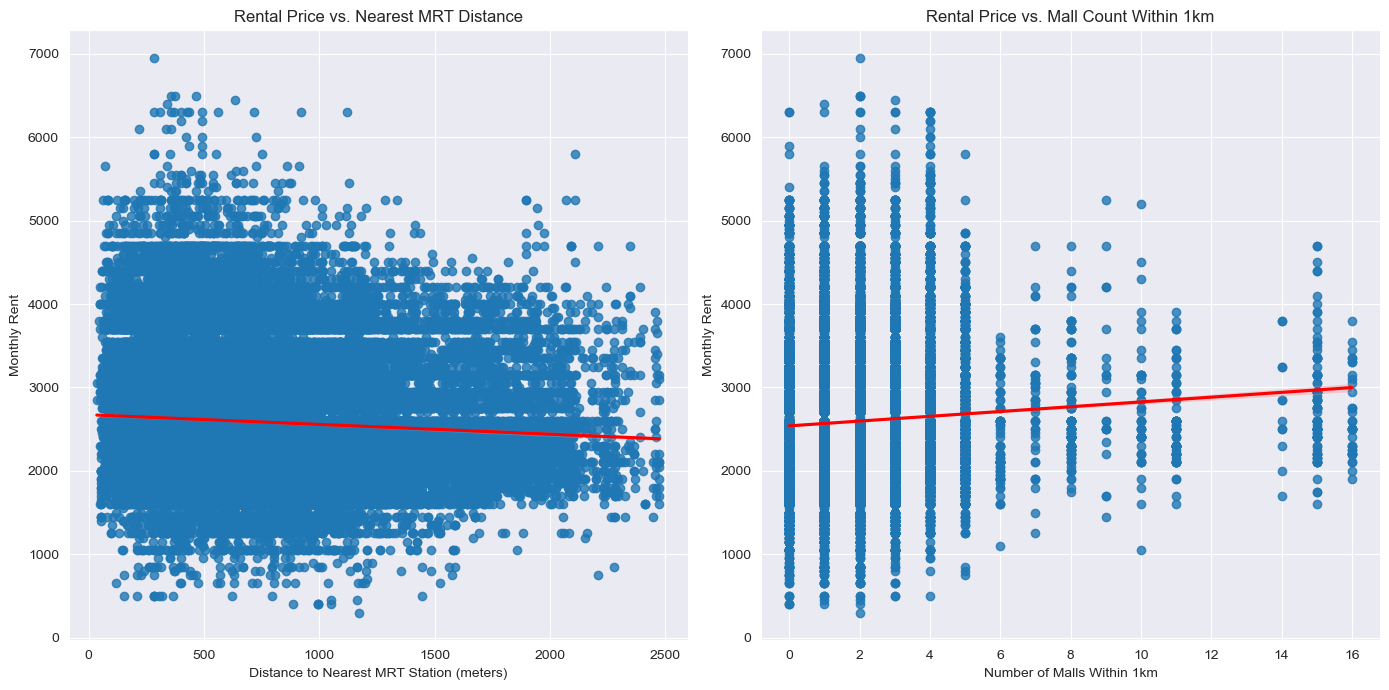

(-0.06705821281948995, 0.06138876702658279)

In [8]:
# Calculate the correlation between rental price and proximity to the nearest MRT station
corr_rent_mrt_distance = data['monthly_rent'].corr(data['mrt_nearest_distance'])

# Calculate the correlation between rental price and the number of malls within a 1 km radius
corr_rent_mall_count = data['monthly_rent'].corr(data['mall_count_within_1km'])

# Plot the scatter plots with regression lines for both correlations
plt.figure(figsize=(14, 7))

# Rental Price vs. Nearest MRT Distance
plt.subplot(1, 2, 1)
sns.regplot(x='mrt_nearest_distance', y='monthly_rent', data=data, line_kws={"color": "red"})
plt.title('Rental Price vs. Nearest MRT Distance')
plt.xlabel('Distance to Nearest MRT Station (meters)')
plt.ylabel('Monthly Rent')

# Rental Price vs. Mall Count Within 1km
plt.subplot(1, 2, 2)
sns.regplot(x='mall_count_within_1km', y='monthly_rent', data=data, line_kws={"color": "red"})
plt.title('Rental Price vs. Mall Count Within 1km')
plt.xlabel('Number of Malls Within 1km')
plt.ylabel('Monthly Rent')

plt.tight_layout()
plt.show()

corr_rent_mrt_distance, corr_rent_mall_count

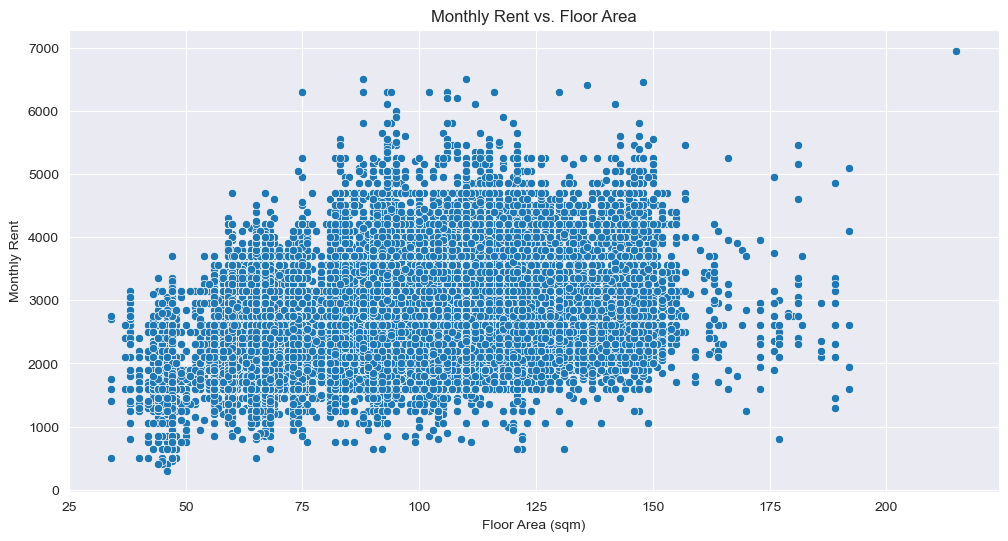

In [16]:
# Extract the relevant columns for analysis of flat characteristics
flat_features = ['floor_area_sqm', 'lease_duration', 'monthly_rent']

# Subset the data for analysis
flat_characteristics_data = data[flat_features]

# Now, let's visualize the relationship between 'floor_area_sqm' and 'monthly_rent' with a scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=flat_characteristics_data, x='floor_area_sqm', y='monthly_rent')
plt.title('Monthly Rent vs. Floor Area')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Monthly Rent')
plt.show()

In [20]:
# Extract the relevant columns for analysis of flat characteristics
flat_features = ['flat_model', 'floor_area_sqm', 'lease_duration', 'monthly_rent']

# Subset the data for analysis
flat_characteristics_data = data[flat_features]
# Separate the numeric features for correlation calculation
numeric_features = ['floor_area_sqm', 'lease_duration', 'monthly_rent']
numeric_data = flat_characteristics_data[numeric_features]

# Calculate the correlation between numeric features and monthly rent
correlation_with_rent = numeric_data.corr()['monthly_rent'].drop('monthly_rent').sort_values(ascending=False)

# For the non-numeric 'flat_model', we still calculate the average rent for each type as before
avg_rent_by_flat_model = flat_characteristics_data.groupby('flat_model')['monthly_rent'].mean().sort_values(ascending=False)

correlation_with_rent, avg_rent_by_flat_model

(floor_area_sqm    0.306466
 lease_duration   -0.225966
 Name: monthly_rent, dtype: float64,
 flat_model
 type s2                   4436.956522
 type s1                   4138.425926
 premium apartment loft    3760.000000
 premium maisonette        3575.000000
 adjoined flat             3343.877551
 terrace                   3325.000000
 3gen                      3183.333333
 dbss                      3150.404313
 model a-maisonette        3138.392857
 maisonette                2978.033473
 apartment                 2878.725962
 premium apartment         2709.678998
 improved                  2636.211052
 model a                   2612.031305
 simplified                2464.689064
 standard                  2444.223986
 model a2                  2439.140271
 new generation            2369.965462
 2-room                    1758.823529
 Name: monthly_rent, dtype: float64)

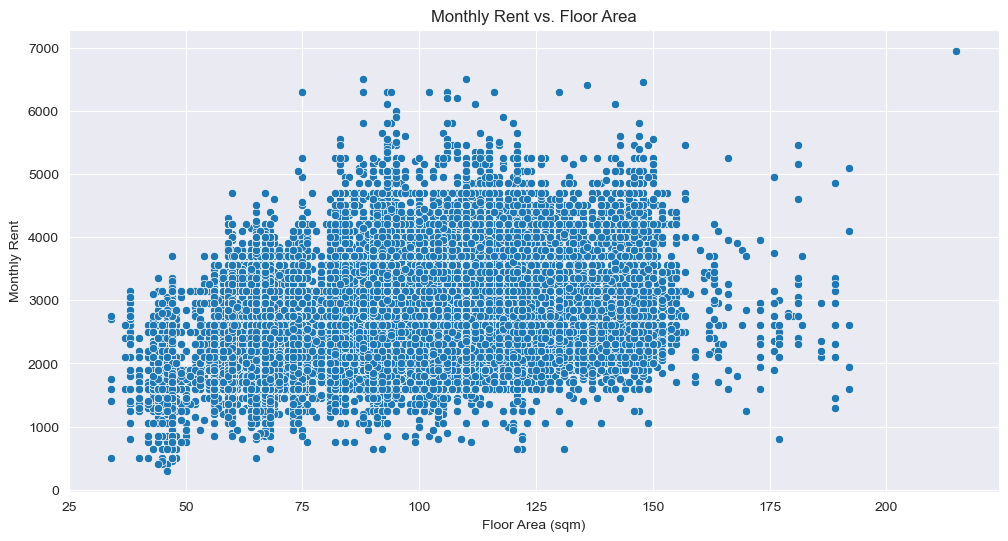

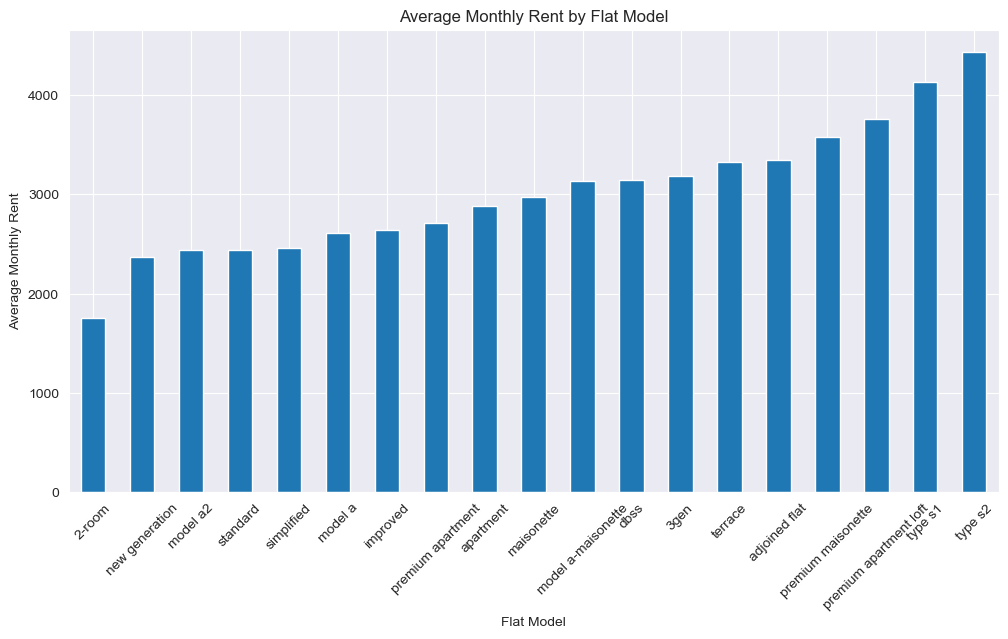

In [21]:
# Now, let's visualize the relationship between 'floor_area_sqm' and 'monthly_rent' with a scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=flat_characteristics_data, x='floor_area_sqm', y='monthly_rent')
plt.title('Monthly Rent vs. Floor Area')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Monthly Rent')
plt.show()

# We will also examine the average rent by flat model using a bar chart
avg_rent_by_flat_model = flat_characteristics_data.groupby('flat_model')['monthly_rent'].mean().sort_values()

plt.figure(figsize=(12, 6))
avg_rent_by_flat_model.plot(kind='bar')
plt.title('Average Monthly Rent by Flat Model')
plt.xlabel('Flat Model')
plt.ylabel('Average Monthly Rent')
plt.xticks(rotation=45)
plt.show()

In [22]:
# Check if there are columns that represent subzones or planning areas
potential_geospatial_columns = [col for col in data.columns if 'zone' in col.lower() or 'area' in col.lower() or 'subzone' in col.lower()]
potential_geospatial_columns

# If such columns exist, we will proceed to calculate the average rental price for each area
# and visualize it on a map. If these columns do not exist, we will need to rely on the latitude and longitude for a more general geospatial analysis.

['floor_area_sqm', 'subzone', 'planning_area']

In [25]:
updated_data = data

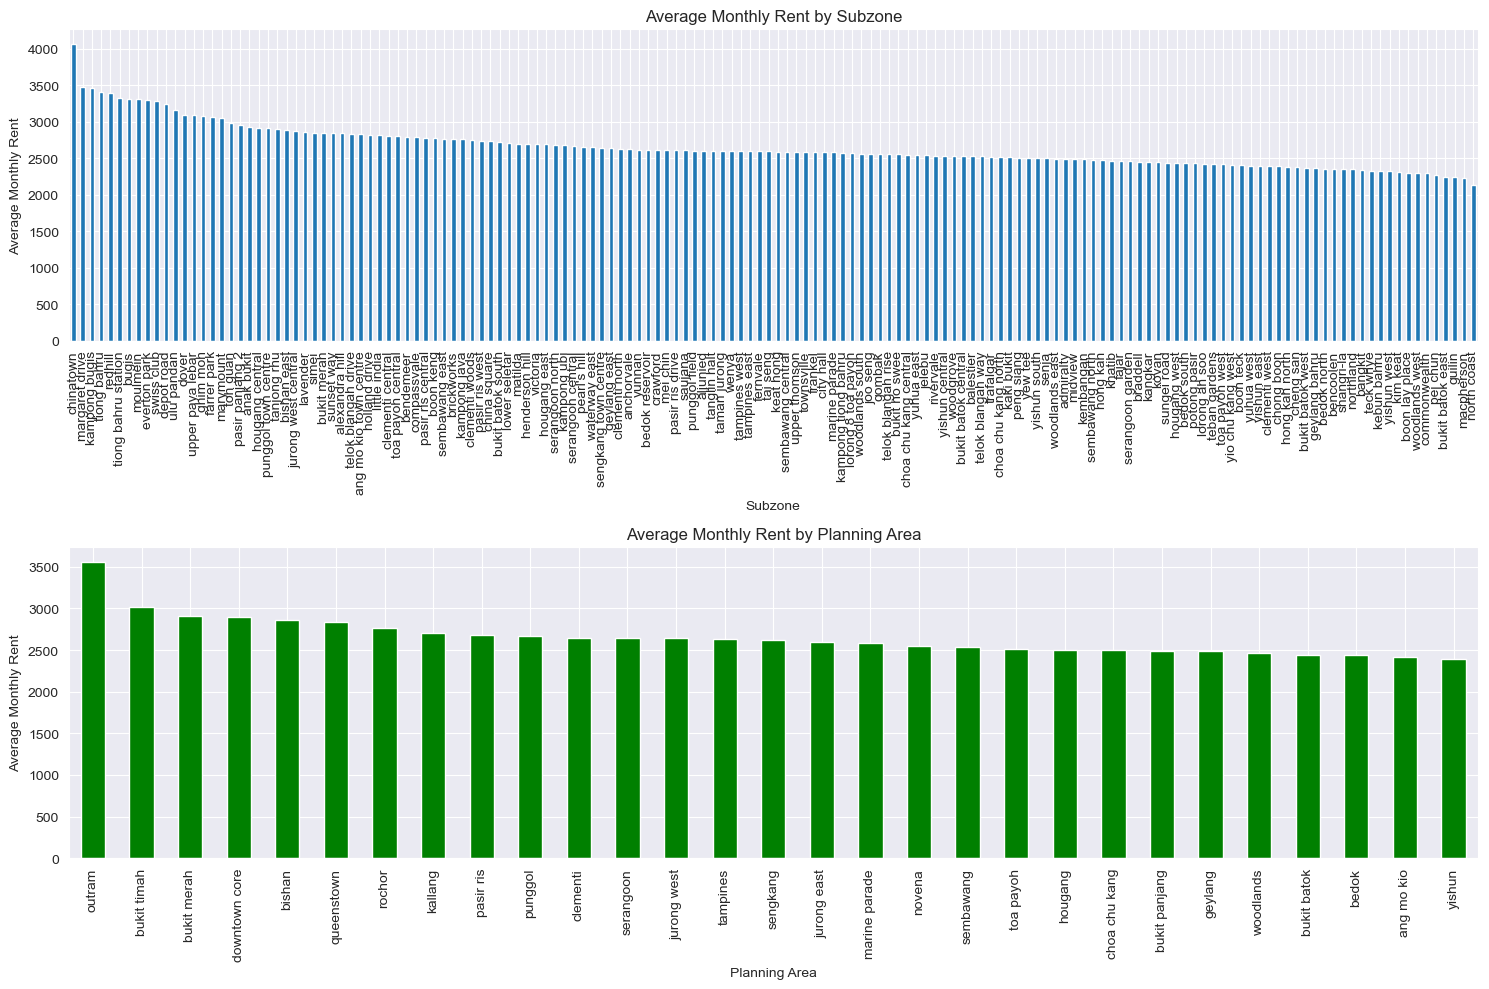

(subzone
 chinatown           4064.971751
 margaret drive      3472.679045
 kampong bugis       3461.111111
 tiong bahru         3413.333333
 redhill             3399.514563
 pei chun            2264.935065
 bukit batok east    2245.307443
 guilin              2237.941176
 macpherson          2228.697749
 north coast         2133.246073
 Name: monthly_rent, dtype: float64,
 planning_area
 outram           3560.357143
 bukit timah      3017.307692
 bukit merah      2904.113924
 downtown core    2896.212121
 bishan           2867.049408
 woodlands        2466.298251
 bukit batok      2446.109123
 bedok            2438.227223
 ang mo kio       2416.700057
 yishun           2398.090586
 Name: monthly_rent, dtype: float64)

In [26]:
# Calculate the average rental price for each subzone and planning area
avg_rent_by_subzone = updated_data.groupby('subzone')['monthly_rent'].mean().sort_values(ascending=False)
avg_rent_by_planning_area = updated_data.groupby('planning_area')['monthly_rent'].mean().sort_values(ascending=False)

# Since we do not have a mapping tool available in this environment, we will create bar charts for visualization
plt.figure(figsize=(15, 10))

# Average Rent by Subzone
plt.subplot(2, 1, 1)
avg_rent_by_subzone.plot(kind='bar')
plt.title('Average Monthly Rent by Subzone')
plt.xlabel('Subzone')
plt.ylabel('Average Monthly Rent')
plt.xticks(rotation=90)

# Average Rent by Planning Area
plt.subplot(2, 1, 2)
avg_rent_by_planning_area.plot(kind='bar', color='green')
plt.title('Average Monthly Rent by Planning Area')
plt.xlabel('Planning Area')
plt.ylabel('Average Monthly Rent')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# Show top 5 and bottom 5 subzones and planning areas by average rent
top_bottom_subzones = pd.concat([avg_rent_by_subzone.head(5), avg_rent_by_subzone.tail(5)])
top_bottom_planning_areas = pd.concat([avg_rent_by_planning_area.head(5), avg_rent_by_planning_area.tail(5)])

top_bottom_subzones, top_bottom_planning_areas

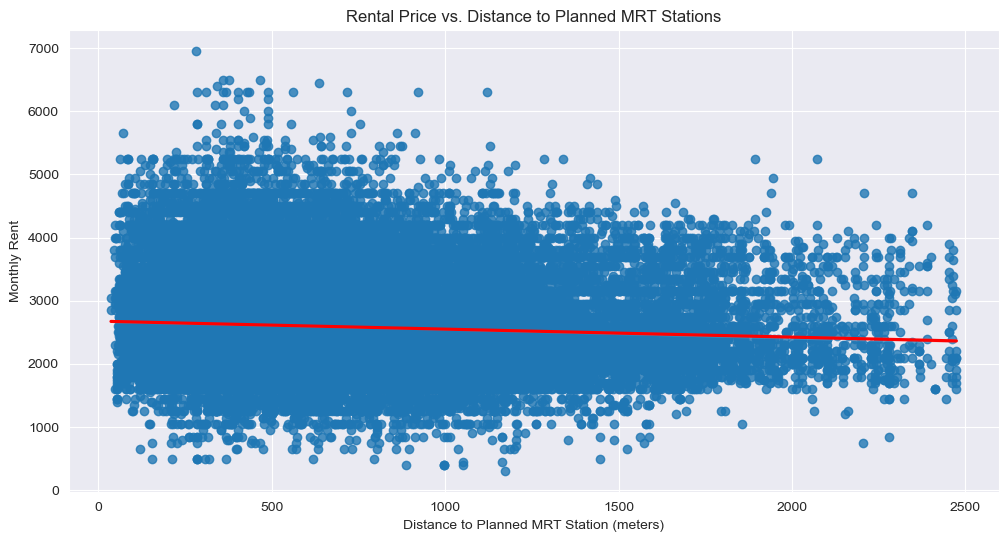

-0.06984347596183073

In [27]:
# Calculate the correlation between rental price and distance to planned MRT stations
corr_rent_planned_mrt_distance = updated_data['monthly_rent'].corr(updated_data['mrt_planned_nearest_distance'])

# Plot the scatter plot with regression line for rental price vs. distance to planned MRT stations
plt.figure(figsize=(12, 6))
sns.regplot(x='mrt_planned_nearest_distance', y='monthly_rent', data=updated_data, line_kws={"color": "red"})
plt.title('Rental Price vs. Distance to Planned MRT Stations')
plt.xlabel('Distance to Planned MRT Station (meters)')
plt.ylabel('Monthly Rent')
plt.show()

corr_rent_planned_mrt_distance

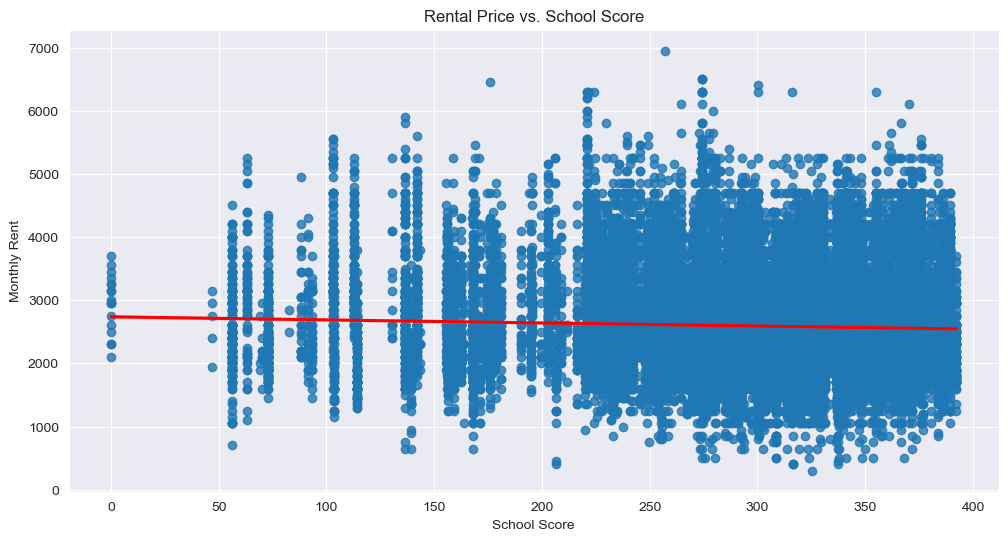

-0.04020468977659838

In [29]:
# Calculate the correlation between rental price and school score
corr_rent_school_score = updated_data['monthly_rent'].corr(updated_data['school_score'])

# Plot the scatter plot with regression line for rental price vs. school score
plt.figure(figsize=(12, 6))
sns.regplot(x='school_score', y='monthly_rent', data=updated_data, line_kws={"color": "red"})
plt.title('Rental Price vs. School Score')
plt.xlabel('School Score')
plt.ylabel('Monthly Rent')
plt.show()

corr_rent_school_score